## **Imports**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from google.colab import drive
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import random
import sys
import os


In [ ]:
# mount drive folder and import custom modules
drive.mount('/content/drive', force_remount=False)
sys.path.insert(0,'/content/drive/MyDrive/Shark_Classification')

from architectures.smallvggnet import SmallVGGNet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Function to List Files in Directory**

In [ ]:
file_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
keep_labels     = ['great_white_shark','hammerhead_shark']

def list_files(indir=os.getcwd(),valid_extensions=file_extensions,valid_labels=keep_labels):
    for (rootdir,dirs,files) in os.walk(indir):
        for filename in files:
            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()
            
            # check to see if the file is an image and should be processed
            if valid_extensions is None or ext.endswith(valid_extensions):
                
                # construct the path to the image and yield it
                imagePath = os.path.join(rootdir, filename)
                
                # yield the path if the label should not be dropped 
                if imagePath.split(os.path.sep)[-2] in valid_labels:
                    yield imagePath
            
    return

## **Read Files**

In [ ]:
dataset_path = os.path.join(sys.path[0],'sharks')
output_path= os.path.join(sys.path[0],"output")
    
#obtain image paths and ramdomize it
image_paths = list(list_files(dataset_path))
random.seed(42)
random.shuffle(image_paths)
    
# initialize data and labels list
data, labels, count, max_count = [],[],0,-1

print("[INFO] Reading images from disk. This may take a while ... ")    
for i in image_paths:

    # load the image  and store the image in the data list
    image = cv2.imread(i)
    image = cv2.resize(image, (64, 64))
    data.append(image)
       
    label = i.split(os.path.sep)[-2]
    labels.append(label)
        
    count+=1
    if count==max_count: break

# print label count
label_list = os.listdir(dataset_path)
for l in label_list: print("label: {} counts: {}".format(l,labels.count(l)))

[INFO] Reading images from disk. This may take a while ... 
label: great_white_shark counts: 928
label: mako counts: 0
label: tiger_shark counts: 0
label: hammerhead_shark counts: 744
label: whale_shark counts: 0


## **Data Preprocessing**

### **Scale Images**

In [ ]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data,dtype="float") / 255.0
labels = np.array(labels)

### **Train/Test Split**

In [ ]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.25, random_state=42)

###**One Hot-Encoding**

In [ ]:
original_classes = trainY
    
# integer encode
label_encoder = LabelEncoder()
trainY = label_encoder.fit_transform(trainY)
testY  = label_encoder.transform(testY)
    
#print(original_classes[0:10])
#print(trainY[0:10])
u, indices =np.unique(trainY,return_index=True)
classes = [original_classes[i] for i in indices]
#print(classes)
  
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
trainY = trainY.reshape(len(trainY), 1)
trainY = onehot_encoder.fit_transform(trainY)
testY = testY.reshape(len(testY), 1)
testY = onehot_encoder.transform(testY)
#print(trainY[0:10])

###**Data Augmentation**

In [ ]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                          height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                          horizontal_flip=True, fill_mode="nearest")

##**Define Model and Compile**

In [ ]:
# initialize our VGG-like Convolutional Neural Network
model = SmallVGGNet.build(width=64, height=64, depth=3,classes=len(classes))

# initialize our initial learning rate and # of epochs to train for
INIT_LR = 1
EPOCHS = 1000
BS = 128

# define early stopping callback
callback= EarlyStopping(
          monitor="val_loss",
          patience=20,
          mode="auto",
          restore_best_weights=True,
          )
    
# compile the model using SGD as our optimizer and categorical
# cross-entropy loss (you'll want to use binary_crossentropy
# for 2-class classification)
print("[INFO] training network...")
opt = SGD(learning_rate=INIT_LR,decay=0.005)#,decay=INIT_LR/EPOCHS
#opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] training network...


##**Train Model**

In [ ]:
# train the network
H = model.fit(x=aug.flow(trainX, trainY, batch_size=BS),
              validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
              epochs=EPOCHS,callbacks=[callback])

Epoch 1/1000
9/9 [==============================] - 3s 202ms/step - loss: 2.8016 - accuracy: 0.5710 - val_loss: 38065.8438 - val_accuracy: 0.5311
Epoch 2/1000
9/9 [==============================] - 1s 151ms/step - loss: 2.3921 - accuracy: 0.5746 - val_loss: 4592.1431 - val_accuracy: 0.5311
Epoch 3/1000
9/9 [==============================] - 1s 153ms/step - loss: 1.2768 - accuracy: 0.6403 - val_loss: 961.1270 - val_accuracy: 0.4713
Epoch 4/1000
9/9 [==============================] - 1s 150ms/step - loss: 0.7481 - accuracy: 0.6812 - val_loss: 202.7712 - val_accuracy: 0.4833
Epoch 5/1000
9/9 [==============================] - 1s 156ms/step - loss: 0.7747 - accuracy: 0.6679 - val_loss: 100.0646 - val_accuracy: 0.4689
Epoch 6/1000
9/9 [==============================] - 1s 158ms/step - loss: 0.7280 - accuracy: 0.6714 - val_loss: 122.3182 - val_accuracy: 0.4689
Epoch 7/1000
9/9 [==============================] - 1s 152ms/step - loss: 0.5766 - accuracy: 0.7345 - val_loss: 17.7880 - val_accurac

##**Evaluate the Network**

[INFO] evaluating network...
                   precision    recall  f1-score   support

great_white_shark       0.86      0.88      0.87       222
 hammerhead_shark       0.86      0.84      0.85       196

         accuracy                           0.86       418
        macro avg       0.86      0.86      0.86       418
     weighted avg       0.86      0.86      0.86       418



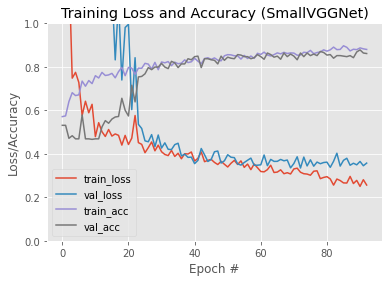

<Figure size 432x288 with 0 Axes>

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(x=testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1), target_names=classes))
#print(confusion_matrix(testY.argmax(axis=1),predictions.argmax(axis=1), labels=classes))
    
# plot the training loss and accuracy
N = np.arange(0, len(H.history["loss"]))
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (SmallVGGNet)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.show()
plt.savefig(os.path.join(output_path,'smallvggnet_plot.png'))

##**Save the Model**

In [ ]:
# save the model and label binarizer to disk
save = False
if save:
  print("[INFO] serializing network and label binarizer...")
  model.save(os.path.join(output_path,'smallvggnet.model'), save_format="h5")
  f = open(os.path.join(output_path,'smallvggnet.pickle'), "wb")
  f.write(pickle.dumps(classes))
  f.close()